In [1]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
import scipy
import networkx as nx
import time

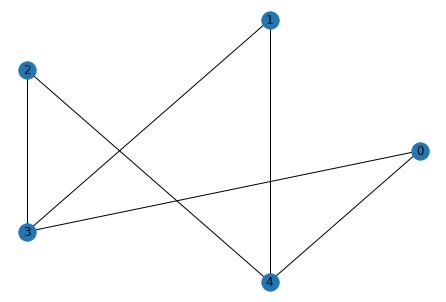

In [2]:
visible_states = [0, 1, 2]
hidden_states = [3, 4]
G = nx.Graph()
G.add_nodes_from(visible_states)
G.add_nodes_from(hidden_states)
G.add_edges_from([(i, j) for i in visible_states for j in hidden_states])
nx.draw_circular(G, with_labels=True)

In [41]:
num_qubits = len(visible_states) + len(hidden_states)

transverse_params = np.random.normal(loc=2, scale=0, size=num_qubits)
single_params = np.random.normal(scale=4, size=num_qubits)
double_params =  {tuple(sorted(edge)): np.random.normal(scale=.01) for edge in G.edges}


H = np.zeros((2 ** num_qubits, 2 ** num_qubits))

pauli_z = np.array([[1, 0], [0, -1]])
pauli_x = np.array([[0, 1], [1, 0]])
identity = np.array([[1, 0], [0, 1]])

for i, b in enumerate(single_params):
    m = b
    for j in range(num_qubits):
        if j == i:
            m = np.kron(m, pauli_z)
        else:
            m = np.kron(m, identity)
    H = np.subtract(H, m)

for i, (a, b) in enumerate(G.edges()):
    m = double_params[(a, b)]
    for j in range(num_qubits):
        if j == a or j == b:
            m = np.kron(m, pauli_z)
        else:
            m = np.kron(m, identity)
    H = np.subtract(H, m)

for i in range(num_qubits):
    m = transverse_params[i]
    for j in range(num_qubits):
        if j == i:
            m = np.kron(m, pauli_x)
        else:
            m = np.kron(m, identity)
    H = np.subtract(H, m)

In [12]:
from active_coresets.maxcut_vqt import optimize_vqt
from active_coresets.ansatz import ZZansatz

In [13]:
beta = 1

In [ ]:
start_time = time.time()
ansatz = ZZansatz(G)
thermal_state = optimize_vqt(H, beta, ansatz)
total_vqt_time = time.time() - start_time

In [15]:
from qiskit.opflow.primitive_ops import PauliSumOp

In [42]:
start_time = time.time()
H = -1 * beta * H
exp_H = scipy.linalg.expm(H)
partition_function = np.trace(exp_H)
exact_thermal_state = qiskit.quantum_info.DensityMatrix(exp_H / partition_function)

expectations = np.zeros(num_qubits)

for i in range(num_qubits):
    pauli_str = 'I' * (i) + 'Z' + 'I' * (num_qubits - i - 1)
    expectations[i] = exact_thermal_state.expectation_value(PauliSumOp.from_list([(pauli_str, 1)])).real

for (i, j) in G.edges():
    pauli_str = 'I' * (i) + 'Z' + 'I' * (j - i - 1) + 'Z' + 'I' * (num_qubits - j - 1)
    expectation = exact_thermal_state.expectation_value(PauliSumOp.from_list([(pauli_str, 1)])).real
    print(f'Edge: {i} {j} | Expectation: {expectation}')

print(f'Exact expectations: {expectations}')

total_exact_time = time.time() - start_time

Edge: 0 3 | Expectation: 0.23711472790035465
Edge: 0 4 | Expectation: -0.21792557306221402
Edge: 1 3 | Expectation: 0.6519021337854908
Edge: 1 4 | Expectation: -0.5982869153309492
Edge: 2 3 | Expectation: -0.4791483178471742
Edge: 2 4 | Expectation: 0.4393555329589703
Exact expectations: [ 0.3490572   0.95856535 -0.70416273  0.68007688 -0.62409865]


In [39]:
import importlib
import active_coresets.population_annealing
importlib.reload(active_coresets.population_annealing)

from active_coresets.population_annealing import population_annealing

In [44]:
z_expectations, zz_expectations, history = population_annealing(transverse_params, single_params, double_params, 10, 512, 0, 5, 0.2, 1)
print(f'Z expectations: {z_expectations}, ZZ expectations: {zz_expectations}')

Z expectations: [ 0.04726562 -0.06445312  0.06914062  0.028125   -0.046875  ], ZZ expectations: {(0, 3): 0.0013293457031249957, (0, 4): -0.0022155761718749903, (1, 3): -0.0018127441406249943, (1, 4): 0.003021240234374987, (2, 3): 0.001944580078124996, (2, 4): -0.0032409667968749897}


In [54]:
print(history[4][0])
print(np.mean(history[4], axis=0)[0])
print(np.mean(history[4], axis=(0, 1)))

[[ 1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]]
[-0.8671875  -0.9296875  -0.9609375  -0.90625    -0.91015625]
[0.0078125  0.00546875 0.00390625 0.00390625 0.00820313]


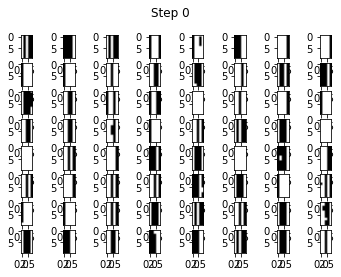

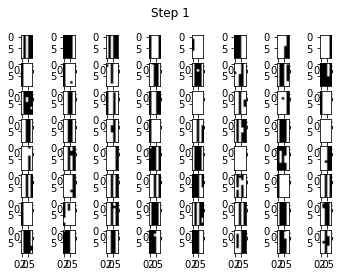

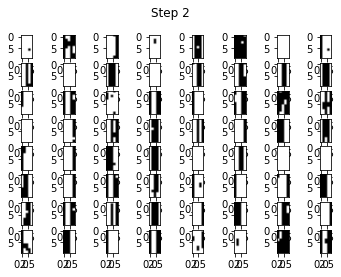

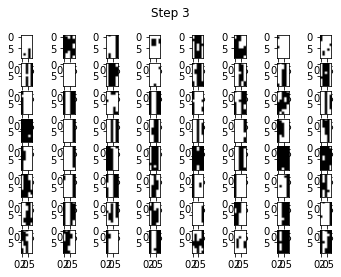

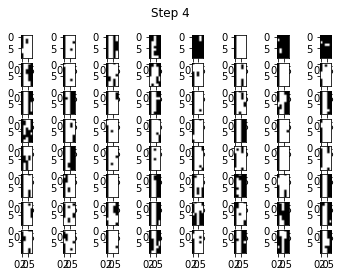

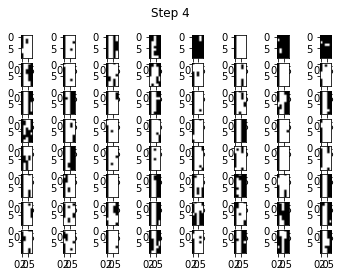

In [106]:
from celluloid import Camera
from IPython.display import display

fig, axs = plt.subplots(8, 8)
camera = Camera(fig)

num_steps = history.shape[0]
num_copies = history.shape[1]
num_units = history.shape[2]

for i in range(num_steps):
    for j in range(num_copies):
        row = j // 8
        axs[row, j - row * 8].imshow(history[i, j], cmap='binary')
        fig.suptitle(f'Step {i}')
    display(fig)
    camera.snap()

anim = camera.animate()
anim.save('animation.gif', writer='imagemagick', fps=1)
